In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
from source.utils import load_data, save_data

C:\Users\Till\AppData\Local\Temp\ipykernel_17052\3637220415.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### **Load cleaned data**

In [3]:
portfolio = load_data('../data/portfolio_cleaned.pkl')
profile = load_data('../data/profile_cleaned.pkl')
transcript = load_data('../data/transcript_cleaned.pkl')

### **Merge profile and transcript datasets**

I use an inner join for the transcript and profile datasets as I deleted user_ids with age 118, no gender and no income. These entries won't help us in classifying users later on in the modeling stage. Then I merge the joined dataset with the portfolio dataset to add the offer type. Finally, I drop all the rows, I won't need to define my target variable.

In [4]:
profile_transcript = pd.merge(transcript, profile, how='inner', on='user_id')
merged = pd.merge(profile_transcript, portfolio, how='left', on='offer_id')
merged.drop(['gender', 'age', 'income', 'member_days', 'amount_spent', 'reward_received', 'offer_reward', 'offer_difficulty'], axis=1, inplace=True)
merged.head(3)

,user_id,status,test_time,offer_id,offers_received,offer_duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,4,7.0,bogo,1.0,1.0,0.0,1.0
1,e2127556f4f64592b11af22de27a7932,offer received,0.0,2906b810c7d4411798c6938adc9daaa5,4,7.0,discount,1.0,1.0,0.0,1.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0.0,f19421c1d4aa40978ebb69ca19b0e20d,6,5.0,bogo,1.0,1.0,1.0,1.0


In [5]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272743 entries, 0 to 272742
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          272743 non-null  object 
 1   status           272743 non-null  object 
 2   test_time        272743 non-null  float64
 3   offer_id         148805 non-null  object 
 4   offers_received  272743 non-null  int64  
 5   offer_duration   148805 non-null  float64
 6   offer_type       148805 non-null  object 
 7   email            148805 non-null  float64
 8   mobile           148805 non-null  float64
 9   social           148805 non-null  float64
 10  web              148805 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 22.9+ MB


### **Examine data and create cross dataset visuals**

Let's have a look at the campaign funnel for discount, discount and informational offers from offer received until offer completed.

<Axes: xlabel='offer_type'>

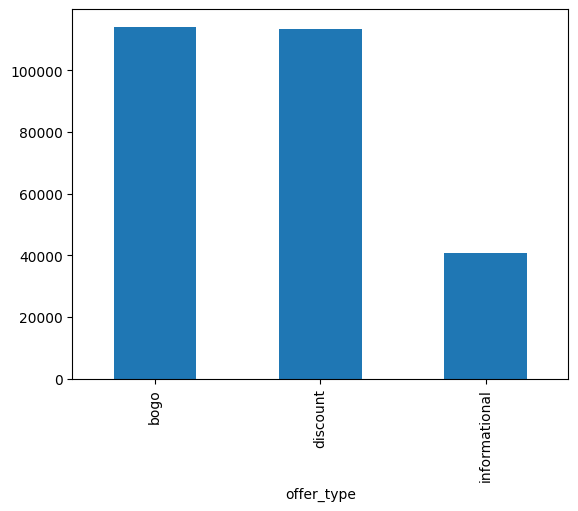

In [40]:
merged['offer_type'].value_counts().plot(kind='bar')

In [7]:
campaign_funnel = merged.groupby(['offer_type','status'])['user_id'].count()
campaign_funnel

offer_type     status         
bogo           offer completed    15258
               offer received     26537
               offer viewed       22039
discount       offer completed    17186
               offer received     26664
               offer viewed       18461
informational  offer received     13300
               offer viewed        9360
Name: user_id, dtype: int64

Text(0.5, 1.0, 'informational')

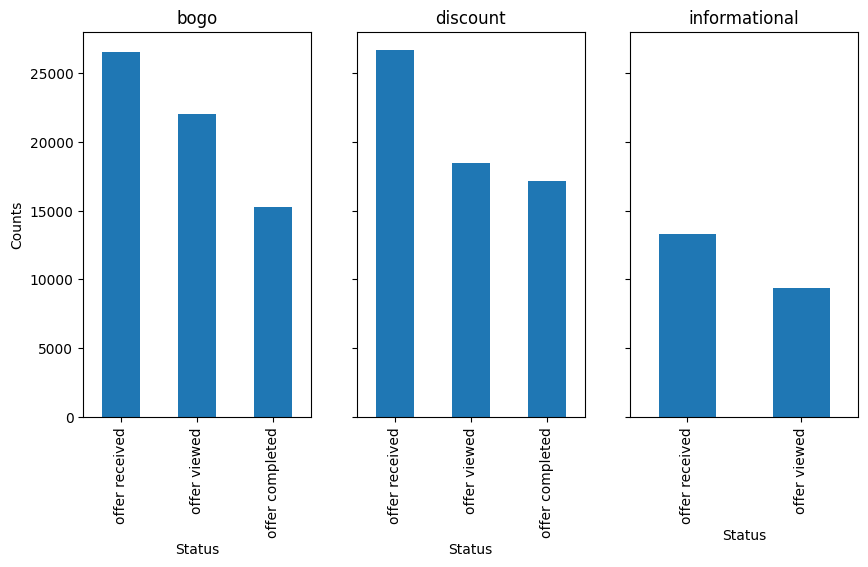

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True)

ax1 = plt.subplot(131)
discount = merged[merged['offer_type'] == 'bogo']['status'].value_counts()
discount.plot(kind='bar', figsize=(10,5))
plt.ylabel('Counts')
plt.xlabel('Status')
plt.title('bogo')

ax2 = plt.subplot(132)
discount = merged[merged['offer_type'] == 'discount']['status'].value_counts()
discount.plot(kind='bar' , figsize=(10,5))
plt.ylabel('Counts')
plt.xlabel('Status')
plt.title('discount')

ax3 = plt.subplot(133)
informational = merged[merged['offer_type'] == 'informational']['status'].value_counts()
informational.plot(kind='bar' , figsize=(10,5))
plt.ylabel('Counts')
plt.xlabel('Status')
plt.title('informational')

Let's have a look at the view and complete rates for the different offer_types:

In [9]:
print('---bogo:---')
print('offer_view_rate:', "{:.1%}".format(campaign_funnel.iloc[2]/campaign_funnel.iloc[1]))
print('offer_complete_rate', "{:.1%}".format(campaign_funnel.iloc[0]/campaign_funnel.iloc[1]))
print('\n')
print('---discount:---')
print('offer_view_rate:', "{:.1%}".format(campaign_funnel.iloc[5]/campaign_funnel.iloc[4]))
print('offer_complete_rate', "{:.1%}".format(campaign_funnel.iloc[3]/campaign_funnel.iloc[4]))
print('\n')
print('---informationl:---')
print('offer_view_rate:', "{:.1%}".format(campaign_funnel.iloc[7]/campaign_funnel.iloc[6]))

---bogo:---
offer_view_rate: 83.1%
offer_complete_rate 57.5%


---discount:---
offer_view_rate: 69.2%
offer_complete_rate 64.5%


---informationl:---
offer_view_rate: 70.4%


### **Define Target Variable**

As the rates vary between the offer types, I decide to build three different machine learning models. For discount, discount and informational offers.  
However, the logic to build the target variables for discount and discount offers is the same.
  
So, let's define our logic whom to send an offer and to whom not:

**discount** and **discount**:  
offer received > offer viewed > transaction > offer completed -> send offer = 1  
transaction                                                   -> don't send offer = 0  
offer received > transaction                                  -> don't send offer = 0  
offer received > transaction > offer viewed                   -> don't send offer = 0  
offer received > transaction > offer completed > offer viewed -> don't send offer = 0  
offer received > offer viewed                                 -> don't send offer = 0  

**informational**:  
offer received > offer viewed > transaction                   -> send offer = 1  
transaction                                                   -> don't send offer = 0  
offer received > transaction                                  -> don't send offer = 0  
offer received > transaction > offer viewed                   -> don't send offer = 0  

Above, we basically **send** those users an **offer** who **made a transaction within the offer duration and after they viewed the offer**.  
In all other possible combinations, users make a transaction without viewing the offer. Hence, we can assume that they  
would have made a purchase either way. So, we won't send them an offer as this would result in forgone revenues.  

Let's code this logic:

1. We start by filtering the dataset by user_id and test_time.

In [10]:
merged.sort_values(by=['user_id', 'test_time'], inplace=True)
merged.head()

,user_id,status,test_time,offer_id,offers_received,offer_duration,offer_type,email,mobile,social,web
49807,0009655768c64bdeb2e877511632db8f,offer received,7.0,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0
68955,0009655768c64bdeb2e877511632db8f,offer viewed,8.0,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0
79394,0009655768c64bdeb2e877511632db8f,transaction,9.5,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN
101115,0009655768c64bdeb2e877511632db8f,offer received,14.0,3f207df678b143eea3cee63160fa8bed,5,4.0,informational,1.0,1.0,0.0,1.0
124373,0009655768c64bdeb2e877511632db8f,offer viewed,15.5,3f207df678b143eea3cee63160fa8bed,5,4.0,informational,1.0,1.0,0.0,1.0


2. Forward fill missing cells by user_id, so we have the offer id of the last offer in transaction rows

In [11]:
merged.update(merged.groupby(['user_id']).ffill())
merged.head()

,user_id,status,test_time,offer_id,offers_received,offer_duration,offer_type,email,mobile,social,web
49807,0009655768c64bdeb2e877511632db8f,offer received,7.0,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0
68955,0009655768c64bdeb2e877511632db8f,offer viewed,8.0,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0
79394,0009655768c64bdeb2e877511632db8f,transaction,9.5,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0
101115,0009655768c64bdeb2e877511632db8f,offer received,14.0,3f207df678b143eea3cee63160fa8bed,5,4.0,informational,1.0,1.0,0.0,1.0
124373,0009655768c64bdeb2e877511632db8f,offer viewed,15.5,3f207df678b143eea3cee63160fa8bed,5,4.0,informational,1.0,1.0,0.0,1.0


3. Next, we filter only for the status offer viewed, transaction and offer completed.

In [12]:
merged_filtered = merged[(merged['status'] == 'offer viewed') |
                         (merged['status'] == 'transaction') |
                         (merged['status'] == 'offer completed')
                         ].sort_values(by=['user_id', 'test_time'])

4. Now, we create a new dataset with rows shifted by 1 and concate it together with the originial dataset. This way we can compare whether the sequence offer viewed and transaction is holding as well as the transaction took place within the offer duration. In my opinion it's secondary whether the offer is completed since offers are all about activating a customer.

In [13]:
merged_filtered['offer_id_shifted'] = merged_filtered.groupby(['user_id', 'offer_id'])['offer_id'].shift(1)
merged_filtered.head()

,user_id,status,test_time,offer_id,offers_received,offer_duration,offer_type,email,mobile,social,web,offer_id_shifted
68955,0009655768c64bdeb2e877511632db8f,offer viewed,8.00,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0,NaN
79394,0009655768c64bdeb2e877511632db8f,transaction,9.50,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0,5a8bc65990b245e5a138643cd4eb9837
124373,0009655768c64bdeb2e877511632db8f,offer viewed,15.50,3f207df678b143eea3cee63160fa8bed,5,4.0,informational,1.0,1.0,0.0,1.0,NaN
149522,0009655768c64bdeb2e877511632db8f,transaction,17.25,f19421c1d4aa40978ebb69ca19b0e20d,5,5.0,bogo,1.0,1.0,1.0,1.0,NaN
149523,0009655768c64bdeb2e877511632db8f,offer completed,17.25,f19421c1d4aa40978ebb69ca19b0e20d,5,5.0,bogo,1.0,1.0,1.0,1.0,f19421c1d4aa40978ebb69ca19b0e20d


Create a column completed_offer that indicates whether a user reacted to a offer viewed. Then we merge back all rows with status offer received.

In [14]:
merged_filtered['completed_offer'] = np.where(merged_filtered['offer_id_shifted'] == merged_filtered['offer_id'],1,0)

offers_received = merged[(merged['status'] == 'offer received')].copy()
offers_received['offer_id_shifted'] = np.nan
offers_received['completed_offer'] = np.nan

merged_back = pd.concat([merged_filtered, offers_received], axis=0).sort_values(by=['user_id', 'test_time'])

merged_back.head()

,user_id,status,test_time,offer_id,offers_received,offer_duration,offer_type,email,mobile,social,web,offer_id_shifted,completed_offer
49807,0009655768c64bdeb2e877511632db8f,offer received,7.0,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0,NaN,NaN
68955,0009655768c64bdeb2e877511632db8f,offer viewed,8.0,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0,NaN,0.0
79394,0009655768c64bdeb2e877511632db8f,transaction,9.5,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0,5a8bc65990b245e5a138643cd4eb9837,1.0
101115,0009655768c64bdeb2e877511632db8f,offer received,14.0,3f207df678b143eea3cee63160fa8bed,5,4.0,informational,1.0,1.0,0.0,1.0,NaN,NaN
124373,0009655768c64bdeb2e877511632db8f,offer viewed,15.5,3f207df678b143eea3cee63160fa8bed,5,4.0,informational,1.0,1.0,0.0,1.0,NaN,0.0


Next we can split the dataset by offer type and create three distinct datasets.

In [15]:
bogo = merged_back[merged_back['offer_type'] == 'bogo']
discount = merged_back[merged_back['offer_type'] == 'discount']
informational = merged_back[merged_back['offer_type'] == 'informational']

#### bogo & discount offers

First, we can easily filter out those users who reacted successfully to the offers. Let's do that for discount and discount offers.

In [16]:
bogo_completed = bogo[(bogo['completed_offer'] == 1) & (bogo['status'] == 'offer completed')][['user_id', 'offer_id']]\
                     .groupby(['user_id', 'offer_id']).count().reset_index()

discount_completed = discount[(discount['completed_offer'] == 1) & (discount['status'] == 'offer completed')][['user_id', 'offer_id']]\
                             .groupby(['user_id', 'offer_id']).count().reset_index()

Next, let's find those users who didn't purchase anything after receiving an offer:  
offer received -> not seen  
offer received > offer viewed -> not reacted

##### bogo offers

In [17]:
#subset offer ids that have transactions or conversions by person and offer_id
conversion_ids_bogo = bogo[(bogo['status'] == 'transaction') | (bogo['status'] == 'offer completed')][['user_id', 'offer_id']]\
                          .groupby(['user_id', 'offer_id']).count().reset_index()

#check for unique person-offer_id pairs that consist of offers received 
offers_received_only_bogo = bogo[['user_id', 'offer_id']][bogo['status'] == 'offer received'].groupby(['user_id', 'offer_id']).count().reset_index()

#create merged dataset to diffrentiate groups
check_merge_bogo = conversion_ids_bogo.merge(offers_received_only_bogo, how='right', on=['user_id', 'offer_id'], indicator=True)

check_merge_bogo.head()

,user_id,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,both
1,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,both
2,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,both
3,0020c2b971eb4e9188eac86d93036a77,ae264e3637204a6fb9bb56bc8210ddfd,right_only
4,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,both


In [18]:
# find user_id and offer_id for offers users have seen
not_seen_reacted_bogo = check_merge_bogo[check_merge_bogo['_merge'] == 'right_only']
not_seen_reacted_bogo  = not_seen_reacted_bogo.merge(merged,how='left',on=['user_id', 'offer_id'])
not_reacted_bogo = not_seen_reacted_bogo[not_seen_reacted_bogo['status'] == 'offer viewed'][['user_id', 'offer_id']]\
                                        .groupby(['user_id', 'offer_id']).count().reset_index()

# find user_id and offer_id for offers users haven't seen
not_seen_reacted_bogo.drop(['_merge'], axis=1, inplace=True)
not_seen_bogo = not_seen_reacted_bogo.merge(not_reacted_bogo[['user_id', 'offer_id']], how='left', indicator=True)
not_seen_bogo = not_seen_bogo[not_seen_bogo['_merge'] == 'left_only'][['user_id', 'offer_id']].copy()

##### discount offers

In [19]:
#subset offer ids that have transactions or conversions by person and offer_id
conversion_ids_discount = discount[['user_id', 'offer_id']][(discount['status'] == 'transaction') | (discount['status'] == 'offer completed')]\
                                  .groupby(['user_id', 'offer_id']).count().reset_index()

#check for unique person-offer_id pairs that consist of offers received 
offers_received_only_discount = discount[['user_id', 'offer_id']][discount['status'] =='offer received'].groupby(['user_id', 'offer_id']).count().reset_index()

#create merged dataset to diffrentiate groups
check_merge_discount = conversion_ids_discount.merge(offers_received_only_discount, how='right', on=['user_id', 'offer_id'], indicator=True)

check_merge_discount.head()

,user_id,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,both
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,both
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,both
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,both
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,both


In [20]:
# find user_id and offer_id for offers users have seen
not_seen_reacted_discount = check_merge_discount[check_merge_discount['_merge'] == 'right_only']
not_seen_reacted_discount  = not_seen_reacted_discount.merge(merged,how='left',on=['user_id', 'offer_id'])
not_reacted_discount = not_seen_reacted_discount[not_seen_reacted_discount['status'] == 'offer viewed'][['user_id', 'offer_id']].groupby(['user_id', 'offer_id']).count().reset_index()

# find user_id and offer_id for offers users haven't seen
not_seen_reacted_discount.drop(['_merge'], axis=1, inplace=True)
not_seen_discount = not_seen_reacted_discount.merge(not_reacted_discount[['user_id', 'offer_id']], how='left', indicator=True)
not_seen_discount = not_seen_discount[not_seen_discount['_merge'] == 'left_only'][['user_id', 'offer_id']].copy()

Lastly, let's find those people that have made a transaction either way for bogo and discount offers:

In [21]:
transaction_anyway_bogo = bogo[(bogo['status'] == 'offer completed') & (bogo['completed_offer'] !=1 )][['user_id', 'offer_id']]\
                              .groupby(['user_id', 'offer_id']).count().reset_index()

transaction_anyway_discount = discount[(discount['status'] == 'offer completed') & (discount['completed_offer'] != 1)][['user_id', 'offer_id']]\
                                      .groupby(['user_id', 'offer_id']).count().reset_index()

Let's label those send_offer = 1 who completeted an offer after viewing it and label those send_offer = 0 who have seen an offer but haven't reacted, haven't even seen the offer and haven't reacted or who have purchased something without viewing an offer.

In [22]:
bogo_completed['send_offer'] = 1
not_reacted_bogo['send_offer'] = 0
# not_seen_bogo['send_offer'] = 0
# transaction_anyway_bogo['send_offer'] = 0
# offers_bogo = pd.concat([pd.concat([pd.concat([bogo_completed, not_reacted_bogo], axis=0), not_seen_bogo], axis=0), transaction_anyway_bogo], axis=0)
offers_bogo = pd.concat([bogo_completed, not_reacted_bogo], axis=0)

discount_completed['send_offer'] = 1
not_reacted_discount['send_offer'] = 0
# not_seen_discount['send_offer'] = 0
# transaction_anyway_discount['send_offer'] = 0
# offers_discount = pd.concat([pd.concat([pd.concat([discount_completed, not_reacted_discount], axis=0), not_seen_discount], axis=0), transaction_anyway_discount], axis=0)
offers_discount = pd.concat([discount_completed, not_reacted_discount], axis=0)

In [41]:
offers_bogo.head()

,user_id,offer_id,send_offer
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
1,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
2,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1
3,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
4,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1


In [42]:
offers_discount.head()

,user_id,offer_id,send_offer
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1


#### informational offers

In [23]:
informational.head()

,user_id,status,test_time,offer_id,offers_received,offer_duration,offer_type,email,mobile,social,web,offer_id_shifted,completed_offer
49807,0009655768c64bdeb2e877511632db8f,offer received,7.0,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0,NaN,NaN
68955,0009655768c64bdeb2e877511632db8f,offer viewed,8.0,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0,NaN,0.0
79394,0009655768c64bdeb2e877511632db8f,transaction,9.5,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0,5a8bc65990b245e5a138643cd4eb9837,1.0
101115,0009655768c64bdeb2e877511632db8f,offer received,14.0,3f207df678b143eea3cee63160fa8bed,5,4.0,informational,1.0,1.0,0.0,1.0,NaN,NaN
124373,0009655768c64bdeb2e877511632db8f,offer viewed,15.5,3f207df678b143eea3cee63160fa8bed,5,4.0,informational,1.0,1.0,0.0,1.0,NaN,0.0


Let's check whether transaction happened within offer duration

In [24]:
#get difference in time for informational offers
informational['time_diff'] = informational[(informational['status'] == 'offer received') | 
                                           (informational['status'] == 'transaction')].groupby(['user_id', 'offer_id'])['test_time'].diff()

#create column to track whether transaction happened within offer duration
informational['transaction_within_duration'] = np.where(informational['time_diff'] <= informational['offer_duration'], 1, 0)

informational.head()


C:\Users\Till\AppData\Local\Temp\ipykernel_17052\2666646971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informational['time_diff'] = informational[(informational['status'] == 'offer received') |
C:\Users\Till\AppData\Local\Temp\ipykernel_17052\2666646971.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informational['transaction_within_duration'] = np.where(informational['time_diff'] <= informational['offer_duration'], 1, 0)


,user_id,status,test_time,offer_id,offers_received,offer_duration,offer_type,email,mobile,social,web,offer_id_shifted,completed_offer,time_diff,transaction_within_duration
49807,0009655768c64bdeb2e877511632db8f,offer received,7.0,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0,NaN,NaN,NaN,0
68955,0009655768c64bdeb2e877511632db8f,offer viewed,8.0,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0,NaN,0.0,NaN,0
79394,0009655768c64bdeb2e877511632db8f,transaction,9.5,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0,5a8bc65990b245e5a138643cd4eb9837,1.0,2.5,1
101115,0009655768c64bdeb2e877511632db8f,offer received,14.0,3f207df678b143eea3cee63160fa8bed,5,4.0,informational,1.0,1.0,0.0,1.0,NaN,NaN,NaN,0
124373,0009655768c64bdeb2e877511632db8f,offer viewed,15.5,3f207df678b143eea3cee63160fa8bed,5,4.0,informational,1.0,1.0,0.0,1.0,NaN,0.0,NaN,0


Now, we can label those transactions that were completed in time. These are users who are responsive to offers.

In [25]:
informational['responsive_offer'] = np.where((informational['completed_offer'] == 1) & (informational['transaction_within_duration'] == 1), 1, 0)

informational.head()

C:\Users\Till\AppData\Local\Temp\ipykernel_17052\2703696478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informational['responsive_offer'] = np.where((informational['completed_offer'] == 1) & (informational['transaction_within_duration'] == 1), 1, 0)


,user_id,status,test_time,offer_id,offers_received,offer_duration,offer_type,email,mobile,social,web,offer_id_shifted,completed_offer,time_diff,transaction_within_duration,responsive_offer
49807,0009655768c64bdeb2e877511632db8f,offer received,7.0,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0,NaN,NaN,NaN,0,0
68955,0009655768c64bdeb2e877511632db8f,offer viewed,8.0,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0,NaN,0.0,NaN,0,0
79394,0009655768c64bdeb2e877511632db8f,transaction,9.5,5a8bc65990b245e5a138643cd4eb9837,5,3.0,informational,1.0,1.0,1.0,0.0,5a8bc65990b245e5a138643cd4eb9837,1.0,2.5,1,1
101115,0009655768c64bdeb2e877511632db8f,offer received,14.0,3f207df678b143eea3cee63160fa8bed,5,4.0,informational,1.0,1.0,0.0,1.0,NaN,NaN,NaN,0,0
124373,0009655768c64bdeb2e877511632db8f,offer viewed,15.5,3f207df678b143eea3cee63160fa8bed,5,4.0,informational,1.0,1.0,0.0,1.0,NaN,0.0,NaN,0,0


First, we can easily filter out those users who reacted successfully to the offers. Let's do that for informational offers.

In [26]:
info_completed = informational[informational['responsive_offer'] == 1][['user_id', 'offer_id']].groupby(['user_id', 'offer_id']).sum().reset_index()

Next, let's find those users who didn't purchase anything after receiving an offer:  
offer received -> not seen  
offer received > offer viewed -> not reacted

In [27]:
#subset offer ids that have transactions or conversions by person and offer_id
conversion_ids_info = informational[(informational['status'] == 'transaction') | (informational['status'] == 'offer completed')][['user_id', 'offer_id']]\
                                   .groupby(['user_id', 'offer_id']).count().reset_index()

#check for unique person-offer_id pairs that consist of offers received 
offers_received_only_info = informational[informational['status'] =='offer received'][['user_id', 'offer_id']]\
                                         .groupby(['user_id', 'offer_id']).count().reset_index()

#create merged dataset to differentiate groups
check_merge_info = conversion_ids_info.merge(offers_received_only_info, how='right', on=['user_id', 'offer_id'], indicator=True)

check_merge_info.head()

,user_id,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,right_only
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,both
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,both
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,right_only
4,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,both


In [28]:
# find user_id and offer_id for offers users have seen
not_seen_reacted_info = check_merge_info[check_merge_info['_merge'] == 'right_only']
not_seen_reacted_info  = not_seen_reacted_info.merge(merged, how='left', on=['user_id', 'offer_id'])
not_reacted_info = not_seen_reacted_info[not_seen_reacted_info['status'] == 'offer viewed'][['user_id', 'offer_id']].groupby(['user_id', 'offer_id']).count().reset_index()

# find user_id and offer_id for offers users haven't seen
not_seen_reacted_info.drop(['_merge'], axis=1, inplace=True)
not_seen_info = not_seen_reacted_info.merge(not_reacted_info[['user_id', 'offer_id']], how='left', indicator=True)
not_seen_info = not_seen_info[not_seen_info['_merge'] == 'left_only'][['user_id', 'offer_id']].copy()

Lastly, let's find those people that have made a transaction either way for informational offers:

In [29]:
transaction_anyway_info = informational[(informational['status'] == 'transaction') &
                                        ((informational['completed_offer'] !=1 ) &
                                        (informational['transaction_within_duration'] ==1 )) |
                                        ((informational['completed_offer'] ==1 ) &
                                        (informational['transaction_within_duration'] !=1 ))
                                        ][['user_id', 'offer_id']].groupby(['user_id', 'offer_id']).count().reset_index()

transaction_anyway_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5378 entries, 0 to 5377
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   5378 non-null   object
 1   offer_id  5378 non-null   object
dtypes: object(2)
memory usage: 84.2+ KB


Let's label those send_offer = 1 who made a transaction after viewing it and label those send_offer = 0 who have seen an offer but haven't reacted, haven't even seen the offer and haven't reacted or who have purchased something without viewing an offer.

In [30]:
info_completed['send_offer'] = 1
not_reacted_info['send_offer'] = 0
# not_seen_info['send_offer'] = 0
# transaction_anyway_info['send_offer'] = 0
# offers_info = pd.concat([pd.concat([pd.concat([info_completed, not_reacted_info], axis=0), not_seen_info], axis=0), transaction_anyway_info], axis=0)
offers_info = pd.concat([info_completed, not_reacted_info], axis=0)

In [31]:
offers_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7503 entries, 0 to 1675
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     7503 non-null   object
 1   offer_id    7503 non-null   object
 2   send_offer  7503 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


### Adding features to the datasets offers_bogo, offers_discount and offers_info

#### bogo

In [43]:
bogo_prepared = pd.merge(offers_bogo, profile, how='left', on='user_id')
bogo_data = pd.merge(bogo_prepared, portfolio, how='left', on='offer_id')
bogo_data.drop(['user_id', 'offer_type', 'offer_id'], axis=1, inplace=True)
bogo_data.drop_duplicates(inplace=True)
bogo_data.head()

,send_offer,gender,age,income,member_days,offers_received,offer_reward,offer_difficulty,offer_duration,email,mobile,social,web
0,1,M,33,72000.0,461,5,5,5,5,1,1,1,1
1,1,O,40,57000.0,198,5,5,5,7,1,1,0,1
2,1,F,59,90000.0,874,5,10,10,5,1,1,1,1
3,1,F,24,60000.0,622,4,5,5,7,1,1,0,1
4,1,F,24,60000.0,622,4,5,5,5,1,1,1,1


Altering datatypes:

In [44]:
bogo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15455 entries, 0 to 15454
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   send_offer        15455 non-null  int64  
 1   gender            15455 non-null  object 
 2   age               15455 non-null  int64  
 3   income            15455 non-null  float64
 4   member_days       15455 non-null  int64  
 5   offers_received   15455 non-null  int64  
 6   offer_reward      15455 non-null  int64  
 7   offer_difficulty  15455 non-null  int64  
 8   offer_duration    15455 non-null  int64  
 9   email             15455 non-null  int64  
 10  mobile            15455 non-null  int64  
 11  social            15455 non-null  int64  
 12  web               15455 non-null  int64  
dtypes: float64(1), int64(11), object(1)
memory usage: 1.5+ MB


In [34]:
save_data(bogo_data, '../data/bogo_data.pkl')

#### discount

In [45]:
discount_prepared = pd.merge(offers_discount, profile, how='left', on='user_id')
discount_data = pd.merge(discount_prepared, portfolio, how='left', on='offer_id')
discount_data.drop(['user_id', 'offer_type', 'offer_id'], axis=1, inplace=True)
discount_data.drop_duplicates(inplace=True)
discount_data.head()

,send_offer,gender,age,income,member_days,offers_received,offer_reward,offer_difficulty,offer_duration,email,mobile,social,web
0,1,M,33,72000.0,461,5,2,10,7,1,1,0,1
1,1,M,33,72000.0,461,5,2,10,10,1,1,1,1
2,1,O,40,57000.0,198,5,5,20,10,1,0,0,1
3,1,O,40,57000.0,198,5,3,7,7,1,1,1,1
4,1,F,59,90000.0,874,5,2,10,10,1,1,1,1


In [36]:
save_data(discount_data, '../data/discount_data.pkl')

#### informational

In [46]:
info_prepared = pd.merge(offers_info, profile, how='left', on='user_id')
info_data = pd.merge(info_prepared, portfolio, how='left', on='offer_id')
info_data.drop(['user_id', 'offer_type', 'offer_id'], axis=1, inplace=True)
info_data.drop_duplicates(inplace=True)
info_data.head()

,send_offer,gender,age,income,member_days,offers_received,offer_reward,offer_difficulty,offer_duration,email,mobile,social,web
0,1,M,33,72000.0,461,5,0,0,3,1,1,1,0
1,1,F,59,90000.0,874,5,0,0,3,1,1,1,0
2,1,F,24,60000.0,622,4,0,0,3,1,1,1,0
3,1,F,26,73000.0,400,5,0,0,4,1,1,0,1
4,1,F,26,73000.0,400,5,0,0,3,1,1,1,0


In [38]:
save_data(info_data, '../data/info_data.pkl')